# Searching for New Particle Resonances

*Students will “discover” a new particle by characterising a resonant bump in the invariant mass distribution from a set of simulated particle collisions.*

**Topics: data processing (raw data → histograms), curve fitting, regression Relevant packages: NumPy, SciPy, Matplotlib**

Students will be provided with a simulated dataset coming from an $X \rightarrow abc$ decay (i.e. a list
of particle 4-momenta). They will plot the invariant mass of the mother particle and observe by eye a resonant “bump” corresponding to the mother particle.

Students will then write their own regression-based curve-fitting code to fit the background and resonant distributions, thus determining the mother particle mass and decay width. For a more particle physics-specific tangent, students might look into common curve-fit functions (i.e. Gaussian, Landau, Crystal Ball) and understand when a given functional form is most useful. Once students are happy with the performance of their curve-fitting tool, they will redo the analysis using scipy.optimize (which is a useful module for them to know for future research analyses).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

First, write a python function that will read in the particle collision data from the provided text file.

The first few lines of the data file will look something like:

```
E px py pz charge

<event>
1.27893787226 -0.967943427485 -0.196782063814 0.4972631904 1
0.65484957674 0.0799580860542 0.085630174222 0.621646982287 -1
1.07972424322 -0.634807604926 -0.394274396233 -0.750563397282 -1
1.73527280522 1.42962557946 0.48622159803 -0.272846669269 1
</event>

```

The first line is a header telling you what information is provided for each particle.

Collision events begin with a line ```<event>``` and end with a line ```</event>```. Each line in a given event represents a particle.

In [2]:
# Write your function here

def read_in_particle_data(path_to_file):

    """
    INPUTS:
    
    filename: a string containing the absolute filepath to the collision dataset
    
    **********
    **********
    
    OUTPUTS: 
    
    dict_of_events: a dictionary {event_id: [p4_a, p4_b, p4_c, p4_d]}
    
    """
    
    dict_of_events = {}
    
    event_counter = 0
    
    with open(path_to_file) as infile:
        for line in infile:
            
            if "<event>" in line:
                dict_of_events[event_counter] = []
                
            elif "</event>" in line:
                event_counter += 1
                
            else:
                try: 
                    test_digit = float(line.split()[0]) # testing to see if the first value in the line is a number
                    p_vec = [float(x) for x in line.split()]
                    dict_of_events[event_counter].append(p_vec)
                except:
                    pass
          
    return dict_of_events


In [8]:
path_to_data = "test.txt"

# Execute your function here

dict_of_events = read_in_particle_data(path_to_data)

N_collisions = len(dict_of_events)

First of all, we need to get a sense of what our dataset looks like.

Most particle physics analyses do not use $E$, $p_x$, $p_y$, and $p_z$ as the variables for analysis. Instead, it is easier to analyze the variables $p_T$ (the momentum component transverse to the beam axis), $y$ (rapidity), and $\phi$.

Created histograms of these three variables. What do you notice about them?

In [27]:
def calculate_coords(event):
    
    collision_pT = []
    collision_y = []
    collision_phi = []
    
    for particle in event: 
        pT = np.sqrt(particle[1]**2 + particle[2]**2)
        if ((particle[0]+particle[3])/(particle[0]-particle[3])) > 0:
            y = (0.5)*np.log((particle[0]+particle[3])/(particle[0]-particle[3]))
        else:
            y = 0
        phi = np.arctan2(particle[2], particle[1])
        
        collision_pT.append(pT)
        collision_y.append(y)
        collision_phi.append(phi)
        
    return collision_pT, collision_y, collision_phi

all_pT = []
all_y = []
all_phi = []

for i in range(N_collisions):
    collision_pT, collision_y, collision_phi = calculate_coords(dict_of_events[i])
    all_pT.extend(collision_pT)
    all_y.extend(collision_y)
    all_phi.extend(collision_phi)
    
    

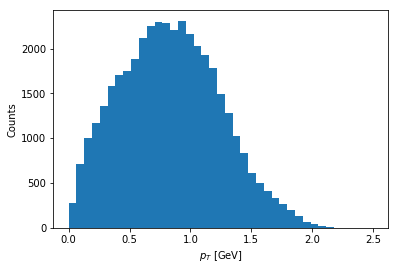

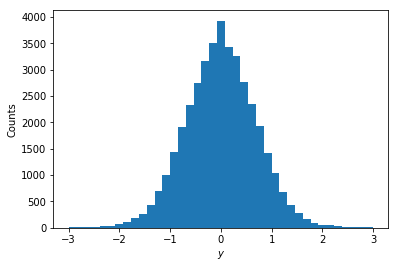

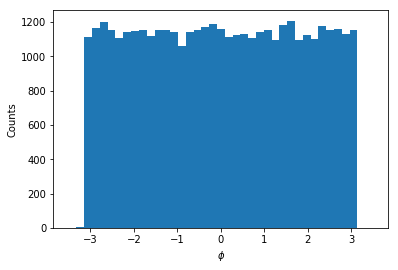

In [28]:
# Write your plotting code here

pT_bins = np.linspace(0,2.5,40)
y_bins = np.linspace(-3,3,40)
phi_bins = np.linspace(-3.5,3.5,40)

def plot_histograms(data, bins, xlabel):
    
    plt.figure()
    plt.hist(data, bins = bins)
    plt.xlabel(xlabel)
    plt.ylabel("Counts")
    plt.show()
    
    
plot_histograms(all_pT, pT_bins, "$p_T$ [GeV]")

plot_histograms(all_y, y_bins, "$y$")
plot_histograms(all_phi, phi_bins, "$\phi$")

Now we want to calculate the mass of the resonant particle $X$ that was produced in the collision event. However, we don't know which two of the four particles in each event decayed from $X$.

For every valid* combination of daughter particles, calculate the hypothetical mass of the mother $X$ particle. Then plot a histgram of all of the invariant masses.

*Note the charge of $X$

Feel free to use or ignore the following function outlines.

In [32]:
def calculate_m2(particle1, particle2):
    
    """
    INPUTS:
    
    particle1: a list [E, px, py, pz] of 4-momentum components 
    particle2: a list [E, px, py, pz] of 4-momentum components 
    
    **********
    **********
    
    OUTPUTS: 
    
    m: A float of the invariant mass of a hypothetical mother particle that could have decayed into particle1 + particle2
    
    """
    
        
    E = particle1[0] + particle2[0]
    px = particle1[1] + particle2[1] 
    py = particle1[2] + particle2[2]
    pz = particle1[3] + particle2[3]
    m2 = E**2 - px**2 - py**2 - pz**2
    
    if m2 > 0:
        return np.sqrt(m2) 
    else:
        return 0


def get_event_invariant_masses(event):
    
    """
    INPUTS:
    
    event: a list of 4-momenta
    
    
    **********
    **********
    
    OUTPUTS: 
    
    masses: a list of the hypothetical invariant masses of the particle X
    
    """
    
            
    positives = []
    negatives = []
    
    for particle in event:
        if particle[-1] < 0:
            negatives.append(particle)
        elif particle[-1] > 0: 
            positives.append(particle)

    masses = []
    
    
    masses.append(calculate_m2(positives[0], negatives[0]))
    masses.append(calculate_m2(positives[0], negatives[1]))
    masses.append(calculate_m2(positives[1], negatives[0]))
    masses.append(calculate_m2(positives[1], negatives[1]))    
    
    return masses


In [33]:
# Execute your code here
    
all_mX = []

for i in range(N_collisions):
    
    all_mX.extend(get_event_invariant_masses(dict_of_events[i]))
  

Then plot the distribution $m$. You should see a bump. Write your estimate of the mass of $X$.

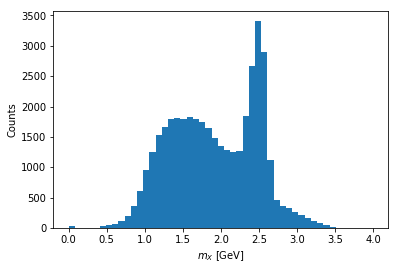

In [34]:
mX_bins = np.linspace(0,4,50)

plot_histograms(all_mX, mX_bins, "$m_X$ [GeV]")

Of course, estimating $m_X$ by eye is not at all rigorous. We should curve fit the distribution, then extract the mean of the fit curve. 

We're going to use scipy.optimize.curvefit to do this.

We can start by fitting the distribution to a Gaussian + Exponential. Define the function for this fit below

In [47]:
def gaussian(x, mu, sigma):
    return np.exp(-((x-mu)/sigma)**2/2.0)
    
def exponential(x, a):
    return np.exp(-x*a)

def model_fit(x, mu, sigma, a, N_sig, N_bkg):
    return N_sig*gaussian(x, mu, sigma) + N_bkg*exponential(x, a)



In [56]:
mX_bins_adj = np.linspace(1.7,3.4,40)



hist, bin_edges = np.histogram(all_mX, mX_bins_adj)

bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])


[  2.48856695e+00  -1.05350990e-01   1.52717348e+00   1.54312380e+03
   1.47814018e+04]


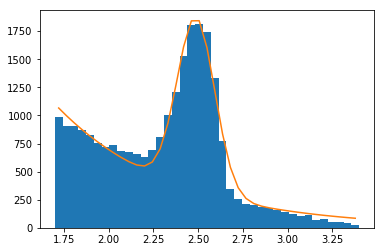

In [57]:
from scipy.optimize import curve_fit

p0 = [2, .05, -1, 1000, 1000]

popt, pcov = curve_fit(model_fit, bin_centers, hist, p0 = p0)
print(popt)

plt.figure()
plt.hist(all_mX, bins = mX_bins_adj)
plt.plot(bin_centers, model_fit(bin_centers, *popt))

plt.show()

Now try a different functional form